<div>
    <h1><center>
        <img src="https://its-live-data.s3.amazonaws.com/documentation/ITS_LIVE_logo.png" width="500"/>
        </center></h1>
    <h1><center>
        glacier velocity point data access<br>
        using Sentinel-2 basemap<br>
        </center></h1>
</div>

---

Author: Mark Fahnestock, Geophysical Institute, University of Alaska Fairbanks
Date: October 28, 2021

--- 

# Intro
This notebook allows you to select a locaiton from high-resolution imagery, fetch all available ITS_LIVE glacier velocities for that location, and plot the results. These steps can be repeated to plot multiple locations on a single figure. 

Underling data is stored on AWS S3 as Zarr datacubes and is accessed without an intermediate server. Glacier velocities are derived from all available Landsat 8, Sentinel-1A/B, Sentinel-2A/B imagery.

Please refer to the <a href="https://its-live.jpl.nasa.gov/">project website</a> for further product infomation and for appraopriate data citation.

 

# Setting up a local environment

at the terminal:
>conda create --name pg5 -c conda-forge h5netcdf fiona imagemagick shapely jupyter netcdf4 psutil h5py zarr matplotlib gdal  xarray  boto3 pyproj ipympl s3fs

activate newly created environment:
> conda activate pg5

start jupyter in browser
> jupyter notebook


In [1]:
#first bunch of imports to read and plot timeseries from datacubes in S3 using xarry->zarr
import xarray as xr
import numpy as np
# import s3fs as s3
from matplotlib import pyplot as plt
from matplotlib.widgets import RectangleSelector
import time

#second bunch to identify datacubes from geojson catalog and picked point
import json
import shapely
import fiona
import pyproj
from shapely import geometry

# gdal for geospatial image io
# recent conda installs have gdal in osgeo - just import gdal if this fails (could catch this if a problem)
from osgeo import gdal, osr

# use widget interface in this notebook for interactive pyplot plots
# %matplotlib notebook
%matplotlib widget

import ipywidgets as wdg
# use ipywidgets for output text to track progress of download call
# output widget is created here, but not displayed until the interactive plot code cell so it stays with plots
outwdgt = wdg.Output(layout={'border': '1px solid blue'})


In [2]:
# first set gdal (and via ogr -> fiona(s3://...)) to access public bucket anonomously
gdal.SetConfigOption('AWS_NO_SIGN_REQUEST', 'YES')

# mz_gd = gdal.Open(
#             '/Volumes/Data/ITSLIVE_mark_mosaics/Alaska_S2_10m_2018/basemap_Alaska_S2_2018_10m_overview_100m.vrt'
#             )
mz_gd = gdal.Open(
            '/vsicurl/https://glacierflow.nyc3.digitaloceanspaces.com/mosaics/ALA/basemap_Alaska_S2_2018_10m_overview_100m.vrt'
            )


mz_srs = mz_gd.GetSpatialRef()
print(f"EPSG:{mz_srs.GetAuthorityCode('PROJCS')}")
map_epsg = mz_srs.GetAuthorityCode('PROJCS')
mz_gt = mz_gd.GetGeoTransform()
mz_npix_x = mz_gd.RasterXSize
mz_npix_y = mz_gd.RasterYSize
print(f'image size ({mz_npix_x},{mz_npix_y}) meters per pixel ({mz_gt[1]},{mz_gt[5]})')

dst = gdal.Translate('/vsimem/mem_img.tif',mz_gd,options='-tr 500 500 -r average')
a = dst.ReadAsArray()
b = np.moveaxis(a, 0, -1)

#get extents of basemap
gt = dst.GetGeoTransform()
inmap_min_x = gt[0]
inmap_max_x = gt[0] + dst.RasterXSize * gt[1]
inmap_min_y = gt[3] + gt[5]*dst.RasterYSize
inmap_max_y = gt[3]

def get_detail_image(mz_gd,ileft,iright,ibottom,itop):
    detaildst = gdal.Translate('/vsimem/mem_img.tif',mz_gd,options=f'-projwin {ileft} {itop} {iright} {ibottom}')
    a = detaildst.ReadAsArray()
    b = np.moveaxis(a, 0, -1)

    #get extents of basemap
    gt = detaildst.GetGeoTransform()
    detailmap_min_x = gt[0]
    detailmap_max_x = gt[0] + detaildst.RasterXSize * gt[1]
    detailmap_min_y = gt[3] + gt[5]*detaildst.RasterYSize
    detailmap_max_y = gt[3]
    
    return((b,(detailmap_min_x,detailmap_max_x,detailmap_min_y,detailmap_max_y)))


EPSG:3338
image size (280000,170000) meters per pixel (10.0,-10.0)


In [3]:
class timeseriesException(Exception):
    pass

def get_timeseries(inpointxy,point_epsg_str):
    
    start = time.time()
    
    if point_epsg_str != '4326':
        # point not in lon,lat, set up tranformation and convert it to lon,lat (epsg:4326)
        inPROJtoLL = pyproj.Transformer.from_proj(f'epsg:{point_epsg_str}','epsg:4326',always_xy=True)
        pointll = inPROJtoLL.transform(*inpointxy)
    else:
        # point already lon,lat
        pointll = inpointxy
    
    # create Shapely point object for inclusion test
    point = geometry.Point(*pointll) # point.coords.xy
    
    # find datacube outline that contains this point in geojson index file
    cubef = None
    
#     s3/its-live-data.jpl.nasa.gov/datacubes/v01/datacubes_100km_v01.json
        
    with fiona.open('s3://its-live-data/test_datacubes/v02/datacubes_catalog.json','r') as infio:
#     with fiona.open('s3://its-live-data.jpl.nasa.gov/datacubes/v01/datacubes_100km_v01.json','r') as infio:
        for f in infio:
            polygeom = geometry.shape(f['geometry'])
            if polygeom.contains(point):
                cubef = f
                
    if cubef:
        print(f'found datacube - elapsed time: {(time.time()-start):10.2f}',flush=True)
        
        if point_epsg_str == cubef['properties']['data_epsg']:
            point_tilexy = inpointxy
        else:
            inPROJtoTilePROJ = pyproj.Transformer.from_proj(f'epsg:{point_epsg_str}',cubef['properties']['data_epsg'],always_xy=True)
            point_tilexy = inPROJtoTilePROJ.transform(*inpointxy)

        # now test if point is in xy box for cube (should be most of time, could fail because of boundary curvature - 4326 box defined by lon,lat corners, but point chosen in basemap projection)                        
        point_tilexy_shapely = geometry.Point(*point_tilexy)
        polygeomxy = geometry.shape(cubef['properties']['geometry_epsg'])
        if not polygeomxy.contains(point_tilexy_shapely):
            raise timeseriesException(f"point is in lat,lon box but not {cubef['properties']['data_epsg']} box!!!!!!!")
            
        # for zarr store modify URL for use in boto open - change http: to s3: and lose s3.amazonaws.com
        incubeurl = cubef['properties']['zarr_url'].replace('http:','s3:').replace('.s3.amazonaws.com','')
        ins3xr = xr.open_dataset(
            incubeurl,
            engine="zarr",
            storage_options={'anon':True},
        )

        print(f'xarray open - elapsed time: {(time.time()-start):10.2f}',flush=True)

        # end for zarr store

        return (ins3xr,point_tilexy)
    
    else:
        raise timeseriesException(f'no datacube found for point {pointll}')

In [4]:
# decorator captures function output in widget
@outwdgt.capture(clear_output=True,wait=True)
def plotfig(pointxy,nax,map_epsg):
    global ins3xr
    global point_v # hopefully these are available in the global context after a call...
    # pointxy is [x,y] coordinate in mapfig projection (map_epsg below), nax is plot axis for time series plot
    start = time.time()
    print(f'finding timeseries for point x={pointxy[0]:10.2f} y={pointxy[1]:10.2f} color {colors[color_index]} symbol {symbols[color_index]}',flush=True)

    ins3xr,point_tilexy = get_timeseries(pointxy,map_epsg) # returns xarray dataset object (used for time axis in plot) and already loaded v time series
    point_v = ins3xr["v"].sel(x=point_tilexy[0],y=point_tilexy[1],method="nearest")

    point_v.load()

    print(f'time series loaded {len(point_v)} points - elapsed time: {(time.time()-start):10.2f}',flush=True)
        
    dt = ins3xr['date_dt'].values 
    dt = dt.astype(float)*1.15741e-14;
    max_dt = 90; # set the maximum image-pair time seperation (dt) that will be plotted
    
    nax.plot(ins3xr.mid_date[dt < max_dt],point_v[dt < max_dt], colors[color_index] + symbols[color_index])
    total_time = time.time()-start
    print(f'elapsed time: {total_time:10.2f} - {len(point_v)/total_time:6.1f} points per second',flush=True)


In [5]:
# # decorator captures function output in widget
# @outwdgt.capture(clear_output=True,wait=True)
# def plotfig(pointxy,nax):
#     global ins3xr,point_v # hopefully these are available in the global context after a call...
#     # pointxy is [x,y] coordinate in mapfig projection (map_epsg below), nax is plot axis for time series plot
#     start = time.time()
#     print(f'finding timeseries for point x={pointxy[0]:10.2f} y={pointxy[1]:10.2f} color {colors[color_index]} symbol {symbols[color_index]}',flush=True)
# #     map_epsg = '3413'
#     ins3xr,point_v = get_timeseries(pointxy,map_epsg) # returns xarray dataset object (used for time axis in plot) and already loaded v time series


#     nax.plot(ins3xr.mid_date,point_v, colors[color_index] + symbols[color_index])
#     total_time = time.time()-start
#     print(f'elapsed time: {total_time:10.2f} - {len(point_v)/total_time:6.1f} points per second',flush=True)

In [6]:
# from first answer here (how to avoid recording clicks from fig zoom - only a click if no drag) 
# https://stackoverflow.com/questions/48446351/distinguish-button-press-event-from-drag-and-zoom-clicks-in-matplotlib
class Click():
    def __init__(self, ax, func, button=1):
        self.ax=ax
        self.func=func
        self.button=button
        self.press=False
        self.move = False
        self.c1=self.ax.figure.canvas.mpl_connect('button_press_event', self.onpress)
        self.c2=self.ax.figure.canvas.mpl_connect('button_release_event', self.onrelease)
        self.c3=self.ax.figure.canvas.mpl_connect('motion_notify_event', self.onmove)

    def onclick(self,event):
        if event.inaxes == self.ax:
            if event.button == self.button:
                self.func(event, self.ax)
    def onpress(self,event):
        self.press=True
    def onmove(self,event):
        if self.press:
            self.move=True
    def onrelease(self,event):
        if self.press and not self.move:
            self.onclick(event)
        self.press=False; self.move=False
        
        
pointxy = [np.nan, np.nan] # define here just to see if it is really set in the callback

# set up color/symbol sequence for plots - will fail after 18 points...
colors = 3*"bgrcmk"
symbols =  "++++++xxxxxxvvvvvv"
color_index = -1


# Define a callback function that will update the map plot and call plotfig to read point data and plot it
def onclick(event, ax):
    global pointxy    # ensures the pointxy from the scope above is assigned the value when changed
    global color_index
    global map_epsg
    
    ptx = event.xdata
    pty = event.ydata

    color_index += 1
    
    # keep map axis from rescaling on point plot
    ax.autoscale(False)
    # plot marker on map at clicked location
    ax.plot(ptx,pty, colors[color_index] + symbols[color_index], mew=4, ms=10)
    
    pointxy = [ptx,pty]
    
    # get time series at point and add it to the time series plot
    plotfig(pointxy,plotax,map_epsg)

Output(layout=Layout(border='1px solid blue'), outputs=({'output_type': 'stream', 'text': 'finding timeseries …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
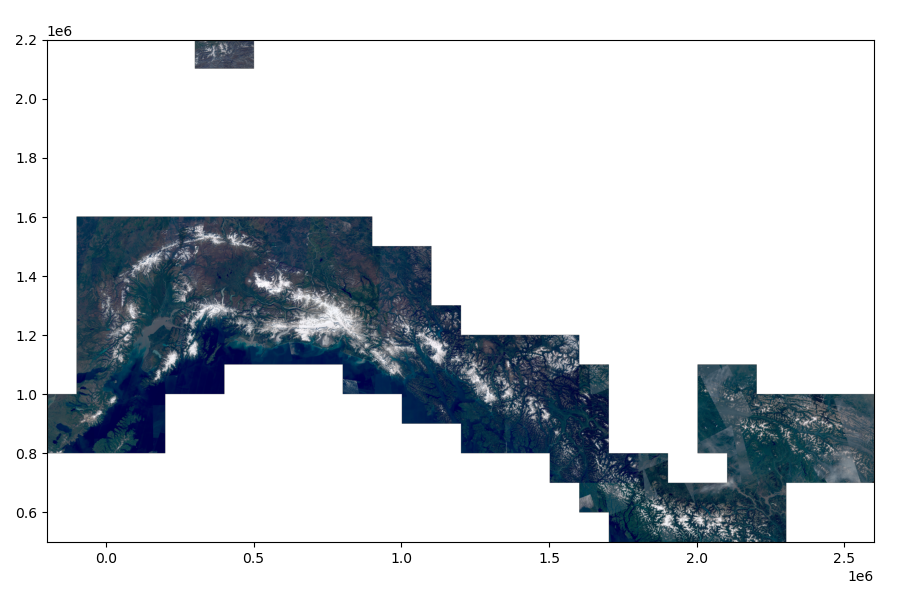

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
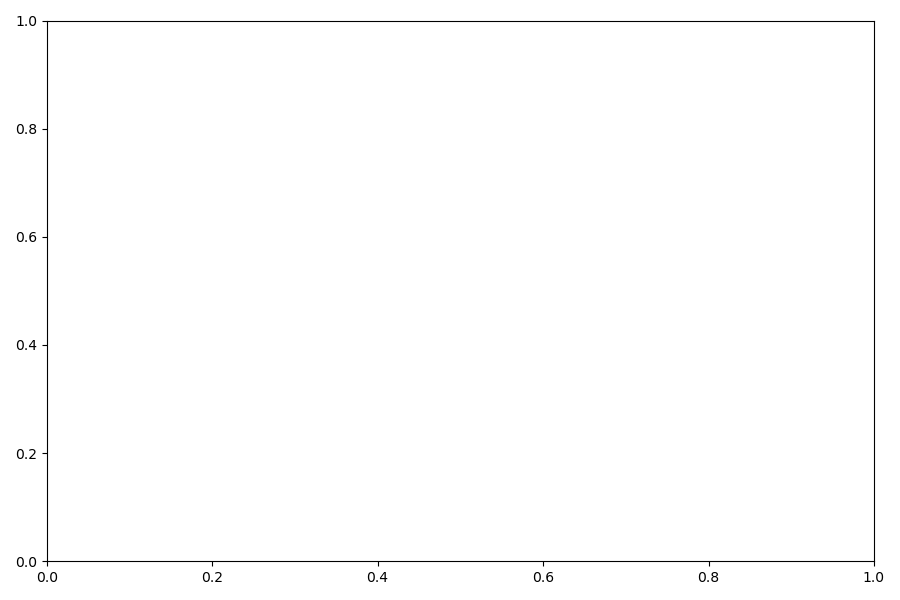

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
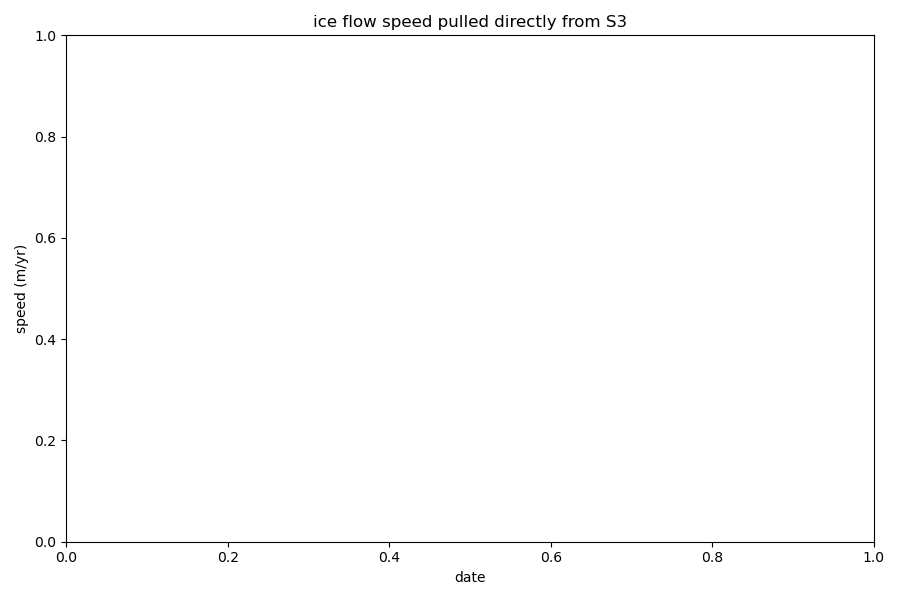

In [8]:
# from matplotlib.widgets import RectangleSelector
# (from https://matplotlib.org/2.0.2/examples/widgets/rectangle_selector.html)

mapfig,mapax = plt.subplots(1,1,figsize=(9,6))
# plt.ion()
# plt.show()
mapfig.tight_layout()
mapax.imshow(b,extent=[inmap_min_x,inmap_max_x,inmap_min_y,inmap_max_y])

detailfig,detailax = plt.subplots(1,1,figsize=(9,6))
# plt.ion()
# plt.show()
detailfig.tight_layout()
# detailax.imshow(b,extent=[inmap_min_x,inmap_max_x,inmap_min_y,inmap_max_y])

click = Click(detailax, onclick, button=1)

# from IPython.display import display
display(outwdgt)

pltfig,plotax = plt.subplots(1,1,figsize=(9,6))
plotax.set_xlabel('date')
plotax.set_ylabel('speed (m/yr)')
plotax.set_title('ice flow speed pulled directly from S3')

pltfig.tight_layout()


# decorator captures function output in widget
@outwdgt.capture(clear_output=True,wait=True)
def line_select_callback(eclick, erelease):
    'eclick and erelease are the press and release events'
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata
    print("(%3.2f, %3.2f) --> (%3.2f, %3.2f)" % (x1, y1, x2, y2))
    print(" The button you used were: %s %s" % (eclick.button, erelease.button))

    print(' Getting full res version.')
    ileft,iright,ibottom,itop = np.round(np.array(toggle_selector.RS.extents)/10.)*10.
    detailimg,(detail_min_x,detail_max_x,detail_min_y,detail_max_y) = get_detail_image(mz_gd,ileft,iright,ibottom,itop)
    detailax.imshow(detailimg,extent=[detail_min_x,detail_max_x,detail_min_y,detail_max_y])

def toggle_selector(event):
    print(' Key pressed.')
    if event.key in ['Q', 'q'] and toggle_selector.RS.active:
        print(' RectangleSelector deactivated.')
        toggle_selector.RS.set_active(False)
    if event.key in ['A', 'a'] and not toggle_selector.RS.active:
        print(' RectangleSelector activated.')
        toggle_selector.RS.set_active(True)
        
# drawtype is 'box' or 'line' or 'none'
toggle_selector.RS = RectangleSelector(mapax, line_select_callback,
                                       drawtype='box', useblit=True,
                                       button=[1, 3],  # don't use middle button
                                       minspanx=500, minspany=500,
                                       spancoords='data',
                                       interactive=True)
# plt.connect('key_press_event', toggle_selector)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
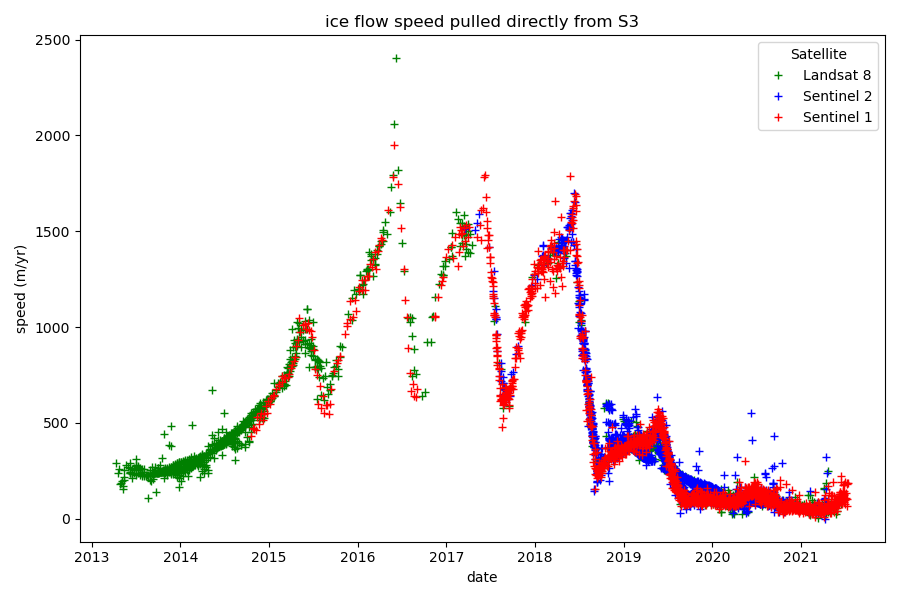

In [10]:
# plot last fetched time series with different symbols/colors for each mission
sat = np.array([x[0] for x in ins3xr['satellite_img1'].values])
dt = ins3xr['date_dt'].values 
dt = dt.astype(float)*1.15741e-14;
max_dt = 90;

sats = np.unique(sat)
sat_plotsym_dict = {
                    '1':'r+',
                    '2':'b+',
                    '8':'g+',
}

sat_label_dict = {
                    '1':'Sentinel 1',
                    '2':'Sentinel 2',
                    '8':'Landsat 8',
}

pltfig2,plotax2 = plt.subplots(1,1,figsize=(9,6))
plotax2.set_xlabel('date')
plotax2.set_ylabel('speed (m/yr)')
plotax2.set_title('ice flow speed pulled directly from S3')

for satellite in sats[::-1]:
    if any(sat==satellite):
        ins3xr.mid_date.values[sat==satellite]
        plotax2.plot(ins3xr.mid_date.values[sat==satellite],point_v[sat==satellite], sat_plotsym_dict[satellite], label=sat_label_dict[satellite])

plotax2.legend(title='Satellite')
pltfig2.tight_layout()

